In [1]:
#檢查載入
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
#測試有無gpu，在執行階段可以更改
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.getcwd()

'/content'

In [5]:
# 雲端執行須執行這行，取得權限
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 雲端執行須執行這行，變更環境路徑
os.chdir("/content/drive/Shareddrives/PerryShare/2020AIGO_Course/code")
os.getcwd()

'/content/drive/Shareddrives/PerryShare/2020AIGO_Course/code'

In [14]:
list_path = "/content/drive/Shareddrives/PerryShare/2020AIGO_Course/code/data_list"
os.path.exists(list_path)

True

In [15]:
data_type_dir = {"label":str, "patient id":str}
train_list = pd.read_csv(os.path.join(list_path, "train_list.csv"), index_col=False, dtype=data_type_dir)
valid_list = pd.read_csv(os.path.join(list_path, "valid_list.csv"), index_col=False, dtype=data_type_dir)
test_list = pd.read_csv(os.path.join(list_path, "test_list.csv"), index_col=False, dtype=data_type_dir)

In [16]:
train_list.head()

,img_name,label,patient id
0,00000001_001.png,0,00000001
1,00000001_002.png,0,00000001
2,00000005_000.png,0,00000005
3,00000005_001.png,0,00000005
4,00000005_002.png,0,00000005


In [17]:
test_list.head()

,img_name,label
0,00000013_004.png,0
1,00000013_005.png,0
2,00000013_006.png,0
3,00000013_007.png,0
4,00000013_008.png,0


## 如果資料不平衡...
[**way1.**](#way1) 針對訓練資料中類別少的類別犯錯給比較重的懲罰，進行學習<br>
[**way2.**](#way2) 把訓練資料中每個類別數量變成一樣多


#### way1. 針對訓練資料中類別少的類別犯錯給比較重的懲罰，進行學習
- 請執行底下 2 個cells
- 計算出 class_weights 比例，以便 model.fit 時，加入 loss 一同計算



In [18]:
unique, counts = np.unique(train_list["label"].values, return_counts=True)
print("unique ", unique)
print("counts: ", counts)
#在數量較少的，給予較大的權重，如果模型沒有學會此label就給予較大的懲罰

unique  ['0' '1']
counts:  [1393  730]


In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',
                    unique,
                    train_list["label"].values)
print(class_weights)

[0.76202441 1.45410959]


#### way2. 把每個類別變的一樣多
- 請執行底下 4 個 cells
- 如果要執行 way2，請""別""執行底下 4 個 cells

[0 1]
[1393  730]


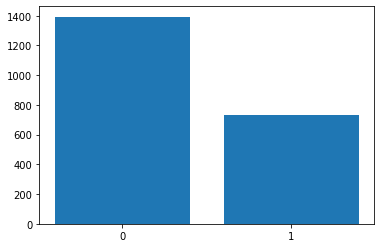

In [24]:
#使用於資料較平衡時
#將較少的一方，複製自身的資料集，補足至多的那方數量，但不要超過5倍
unique, counts = np.unique(train_list["label"].values, return_counts=True)
unique = unique.astype(np.int_)
print(unique)
print(counts)
plt.bar(unique, counts)
plt.xticks(unique)
plt.show()

In [25]:
max_class_name, max_class_num = unique[counts.argmax()], counts.max()
max_class_name, max_class_num

(0, 1393)

In [26]:
from sklearn.utils import shuffle

sampling_ind = []
for class_name, class_num in zip(unique, counts):
    tmp_data = train_list[train_list["label"]==str(class_name)]
    tmp_ind = list(tmp_data.index)
    sampling_ind.extend(tmp_ind)
    if class_num < max_class_num:
        mod_num, res_num = max_class_num//class_num-1, max_class_num%class_num
        for _ in range(mod_num):
            sampling_ind.extend(tmp_ind)
        if res_num != 0:
            sampling_ind.extend(shuffle(tmp_ind)[:res_num])

train_list = train_list.loc[sampling_ind]

<BarContainer object of 2 artists>

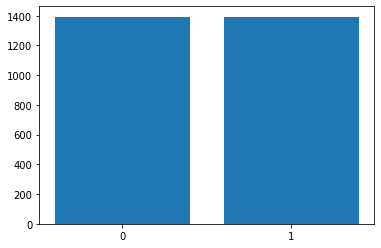

In [27]:
unique, counts = np.unique(train_list["label"].values, return_counts=True)
plt.bar(unique, counts)

## Modeling

In [10]:
# keras是包裝tensorflow，更方便使用
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [11]:
#可使用模型列表 https://keras.io/api/applications/
#本次使用efficientnet，參數較少，目前準確率最高
#efficientnet(B0~B7)是用於不同解析度
from tensorflow.keras.applications.efficientnet import (EfficientNetB5, preprocess_input)

In [28]:
#print出list內有多少類別
num_classes = train_list["label"].unique().shape[0]
num_classes

2

In [29]:
#要注意每個深度學習模型的input size限定
#如本次使用B5模型，限定456X456
img_shape = (456, 456)
#batch size 是指影像一次要看幾筆去學習，模型一次看8筆去更新權重
#batch size 要大於label的類別，這樣本次抽樣才都抽的到
batch_size = 8

In [30]:
#設定每次epoch要看多少資料
#例如1000筆資料，batch_size=8，每次epoch就是1000/8=125次訓練
#每經過一次epoch都要進行一次測試，才會進行下一次的epoch訓練
def num_steps_per_epoch(data_generator, batch_size):
    if data_generator.n % batch_size==0:
        return data_generator.n//batch_size
    else:
        return data_generator.n//batch_size + 1

In [9]:
#ImageDataGenerator，影像讀取套件
#在影像太大量，可方便用到在打開，如一次epoch跑8張就只開8張
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### 如果你需要的只是測試，只需要執行到這邊就可以了
- 請從""大考時間到""再開始執行</br>
[Testing-大考時間到](#Testing-大考時間到)--------------------------------------------------------------------------------

In [31]:
#希望在訓練時，讓影像不要一成不變，但以不讓影像失真為前提
#參數設定:增加旋轉、水平翻轉、垂直翻沝、水平平移、垂直平移
#width_shift_range輸入456x456的0.05=23 pixel，代表0~23 pixel隨機性平移
#最後一個參數是前一個code所寫的影像增強預處理
#這個步驟在training使用，不再testing使用
train_datagen = ImageDataGenerator(
                      rotation_range=90,
                      horizontal_flip=True,
                      vertical_flip=False,
                      width_shift_range=0.05,
                      height_shift_range=0.05,
                      preprocessing_function=preprocess_input
                                   )
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [32]:
#影像路徑
data_path = "/content/drive/Shareddrives/PerryShare/2020AIGO_Course/dataset/data"

In [33]:
#將generator跟train_list做搭配
#參數:train清單、影像資料夾路徑、資料夾內影像名稱、資料夾內影像label、影像大小、一次學幾張
#最後一個參數 categotical 主要拿來解決分類問題
train_generator = train_datagen.flow_from_dataframe(
                          dataframe=train_list,
                          directory=data_path,
                          x_col="img_name",
                          y_col="label",
                          target_size=img_shape,
                          batch_size=batch_size,
                          class_mode='categorical')
#將generator跟valid_list做搭配
#最後一個參數:shuffle，是要不要每次epoch都打亂順序
valid_generator = valid_datagen.flow_from_dataframe(
                          dataframe=valid_list,
                          directory=data_path,
                          x_col="img_name",
                          y_col="label",
                          target_size=img_shape,
                          batch_size=batch_size,
                          class_mode='categorical',
                          shuffle=False)


Found 2786 validated image filenames belonging to 2 classes.
Found 496 validated image filenames belonging to 2 classes.


In [35]:
#weights='imagenet'=載入權重檔imagenet
#include_top=False=不需要原始模型的輸出
pre_model = EfficientNetB5(weights='imagenet', input_shape=(img_shape[0], img_shape[1], 3), include_top=False)
#將2維資料轉成1維
x = layers.GlobalAveragePooling2D()(pre_model.output)
# x = layers.Dense(64, activation="relu")(x)

#將1維資料使用dense layer承接，來分出特徵
#num_classes為前面執行的類別數量
#loss function使用softmax，將輸出數值轉成機率
outputs = layers.Dense(num_classes, activation="softmax")(x)

115277824/115263384 [==============================] - 1s 0us/step


In [36]:
model = tf.keras.models.Model(inputs=pre_model.inputs, outputs=outputs)

In [37]:
model_dir = '/content/drive/Shareddrives/PerryShare/2020AIGO_Course/code/model-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model.h5'.format('efficientnet')
#callbacks是在模型訓練中，希望時時刻刻去觀察
#model_mckp是在觀察驗證的準確率，最後保留眾多次當中最好的一次，所以開啟了save_best_only
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                     monitor='val_accuracy',
                     save_best_only=True)
#earlystop是觀察如果多次沒進度，要讓這個模型休息，設定3次沒進步就停
earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)


callbacks_list = [model_mckp, earlystop]

In [38]:
#learning rate的呼叫
lr = 1e-4
num_epochs = 10

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [ ]:
# model.summary()

### 1st run: 固定前面，訓練 Dense Layer
- 因為 Dense Layer 現在是 initial 所以現在需要大一點的 learning rate 

In [39]:
lr = 1e-4
#optimizer設定模型要往哪個方向走，使得誤差是最小
#categorical_crossentropy 是解決分類問題的loss
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])

In [40]:
#不進行預訓練，因使用別人權重檔，先不訓練更動權重檔
#需要先訓練，自己產上的denselayer
pre_model.trainable = False
# model.summary()

# pre_model.trainable = True
# for each_layer in pre_model.layers[:-5]:
#     each_layer.trainable = False

- 如果要加入 class_weights 進行訓練，把 # 拿掉即可

In [41]:
class_weights = {i:value for i, value in enumerate(class_weights)}

In [ ]:
#開始訓練
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps,
                              epochs=2,
                              validation_data=valid_generator,
                              validation_steps=valid_steps,
                              class_weight=class_weights,
                              callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
349/349 [==============================] - 1045s 3s/step - loss: 0.0455 - accuracy: 0.5022 - val_loss: 2.9450 - val_accuracy: 0.3891


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
349/349 [==============================] - 281s 805ms/step - loss: 0.0039 - accuracy: 0.5000 - val_loss: 3.6616 - val_accuracy: 0.3891


In [ ]:
model_path = model_dir + '/{}-last-model-satge1.h5'.format('efficientnet')
model.save(model_path)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### 2nd run: 鬆開部分前面，一起訓練
- 因為部分卷基層和 Dense Layer 已經不錯，只需要微調 Fine Tune，Learnig rate 須設小一點
- 選擇 1st run 訓練結果中，小考成績最高的那一次，進行 2nd run</br>
  (如果最後一次是最好的，就不用執行底下的 cell)


In [42]:
# 如果 1st 不是最好的，請執行這邊，先清空，再把最好的一次叫出來
try:
    import tensorflow.keras.backend as K
    K.clear_session()
    model_path = model_dir + '/{}-best-model.h5'.format('efficientnet')
    model = keras.models.load_model(model_path)
    print("Load best model.")
except:
    print("Loading error.")
    pass

Load best model.


In [43]:
lr = 1e-5
optimizer = keras.optimizers.Adam(lr)
#loss function使用crossentropy
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])

In [44]:
model.trainable = True
# for each_layer in model.layers[:-10]:
#     each_layer.trainable = False

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              validation_steps=valid_steps,
                              # class_weight=class_weights,
                              callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
349/349 [==============================] - 304s 821ms/step - loss: 1.6309 - accuracy: 0.5000 - val_loss: 1.7698 - val_accuracy: 0.3891
Epoch 2/10
349/349 [==============================] - 281s 804ms/step - loss: 1.0781 - accuracy: 0.5000 - val_loss: 1.1373 - val_accuracy: 0.3891
Epoch 3/10
349/349 [==============================] - 283s 810ms/step - loss: 0.7947 - accuracy: 0.4996 - val_loss: 0.8479 - val_accuracy: 0.3911


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/10
349/349 [==============================] - 286s 818ms/step - loss: 0.7103 - accuracy: 0.5126 - val_loss: 0.7532 - val_accuracy: 0.4214
Epoch 5/10
349/349 [==============================] - 286s 818ms/step - loss: 0.6954 - accuracy: 0.5291 - val_loss: 0.7292 - val_accuracy: 0.4577
Epoch 6/10
349/349 [==============================] - 284s 814ms/step - loss: 0.6924 - accuracy: 0.5273 - val_loss: 0.7229 - val_accuracy: 0.4657
Epoch 7/10
349/349 [==============================] - 281s 805ms/step - loss: 0.6938 - accuracy: 0.5108 - val_loss: 0.7184 - val_accuracy: 0.4758
Epoch 8/10
349/349 [==============================] - 282s 807ms/step - loss: 0.6955 - accuracy: 0.5187 - val_loss: 0.7195 - val_accuracy: 0.4738
Epoch 9/10
349/349 [==============================] - 282s 808ms/step - loss: 0.6880 - accuracy: 0.5477 - val_loss: 0.7139 - val_accuracy: 0.4819
Epoch 10/10
349/349 [==============================] - 281s 805ms/step - loss: 0.6863 - accuracy: 0.5528 - val_loss: 0.7107 

- 依照你的需求看須不要存最後一次模型結果，最後一次不一定是最好的，但是可以留一份紀錄這樣

In [ ]:
model_path = model_dir + '/{}-last-model-stage2.h5'.format('efficientnet')
model.save(model_path)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Testing 大考時間到

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [20]:
# 我們訓練完後，要將最好的一次叫出來，需經過一次清除記憶體，程式碼會經過 try
# 如果不經訓練，僅須測試就會經過 except
try:
    import tensorflow.keras.backend as K
    K.clear_session()
    model_dir = '/content/drive/Shareddrives/PerryShare/2020AIGO_Course/code/model-logs'
    model_path = model_dir + '/{}-best-model.h5'.format('efficientnet')
    model = keras.models.load_model(model_path)
    print("Load best model.")
except:
    model_path = model_dir + '/{}-best-model.h5'.format('efficientnet')
    model = keras.models.load_model(model_path)

Load best model.


In [21]:
data_path = "/content/drive/Shareddrives/PerryShare/2020AIGO_Course/dataset/data"

In [45]:
batch_size = 8

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe=test_list,
                                                  directory=data_path,
                                                  x_col="img_name",
                                                  y_col="label",
                                                  target_size=img_shape,
                                                  batch_size=batch_size,
                                                  class_mode=None,
                                                  shuffle=False)

test_steps = num_steps_per_epoch(test_generator, batch_size)

Found 1162 validated image filenames.


In [46]:
test_steps = num_steps_per_epoch(test_generator, batch_size)

In [47]:
y_test = test_list["label"].values.astype(np.int_)

In [48]:
y_test_predprob = model.predict(test_generator, steps=test_steps)
y_test_pred = y_test_predprob.argmax(-1)

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy_score: 0.455
Specificity = 197/(197+523) = 0.274
Specificity = 332/(110+332) = 0.751


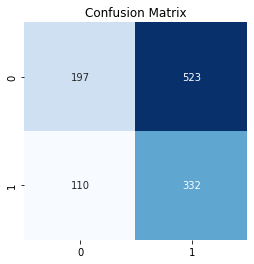

In [51]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")

confusion = confusion_matrix(y_test, y_test_pred)
print(f"Specificity = {confusion[0,0]}/({confusion[0,0]}+{confusion[0,1]}) = {confusion[0,0]/(confusion[0,0]+confusion[0,1]):.3f}")
print(f"Specificity = {confusion[1,1]}/({confusion[1,0]}+{confusion[1,1]}) = {confusion[1,1]/(confusion[1,0]+confusion[1,1]):.3f}")

plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
            cmap="Blues", annot=True, fmt="d", cbar=False,
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.show()